In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import requests

In [2]:
# color styling for heatmaps
bobmap = sns.diverging_palette(
        #127, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        260, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        s = 99,     # saturation (0 - 99)
        l = 50,     # lightness (0 - 99)
        center = "light",
        as_cmap = True,
    )

In [3]:
def calculate_delta(serieslike):
    
    serieslike = serieslike.astype("float64")
    
    returnlist = []
    prev = 0 # no need, but
    for i, elem in enumerate(serieslike):
        if i == 0:
            returnlist.append(elem)
            prev = elem
        else:
            returnlist.append(elem - prev)
            prev = elem
    
    return returnlist

In [4]:
# downloading the latest Protezione Civile data release
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
req = requests.get(url, allow_redirects=False)
with open("dpc-covid19-ita-andamento-nazionale.csv", "wb") as o:
    o.write(req.content)

# prepping the table

df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv", index_col=0)
df = df[df.columns[:-2]] # stripping away the notes
df = df.drop("stato", axis=1) # all ITA cases

In [5]:
# making a slew of new columns
# cooked data is indicated with "*"
df["deceduti giornalieri*"] = calculate_delta(df["deceduti"])
df["tamponi giornalieri*"] = calculate_delta(df["tamponi"])
df["variazione isolamento domiciliare*"] = calculate_delta(df["isolamento_domiciliare"])
df["variazione terapia intensiva*"] = calculate_delta(df["terapia_intensiva"])
df["variazione ricoverati con sintomi*"] = calculate_delta(df["ricoverati_con_sintomi"])
df["variazione isolamento domiciliare*"] = calculate_delta(df["isolamento_domiciliare"])

df["ratio (positivi giornalieri / casi)*"] = list(df["nuovi_positivi"] / df["tamponi giornalieri*"])
df["nuovi positivi normalizzati*"] = df["ratio (positivi giornalieri / casi)*"] * 100

In [6]:
# dropping unwanted columns
remove = [
    "deceduti",
    "isolamento_domiciliare",
    "dimessi_guariti",
    "tamponi",
    "totale_casi",
    "totale_positivi",
    "ratio (positivi giornalieri / casi)*"
]
newcols = [x for x in df.columns if x not in remove]


# custom order
newcols = [
    'variazione terapia intensiva*',
    'variazione ricoverati con sintomi*',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti giornalieri*',
    'variazione isolamento domiciliare*',
    'tamponi giornalieri*',
    'terapia_intensiva',
     'totale_ospedalizzati',
     'ricoverati_con_sintomi',
 ]


# custom order
newcols2 = [
    'variazione terapia intensiva*',
    'variazione isolamento domiciliare*',
    #'variazione_totale_positivi',

    'deceduti giornalieri*',

    'terapia_intensiva',
    #'totale_ospedalizzati',
    'ricoverati_con_sintomi',
    'nuovi positivi normalizzati*',
    

 ]

# data fixing

Data has been incorrectly reported, the following lines will fix the table (by removing the unwanted lines)

In [7]:
df = df[df["nuovi positivi normalizzati*"] > 0].copy()

In [8]:
def draw_bigmap(
    data, columns, 
    skipdays=4, xsize=8, ysize=14, lastdays=None,
    metric="euclidean", figsize=(10,10),
    annot=False, fmt="g", annot_kws={"size":15}, center=0,    
):
    
    data = data[columns].copy()
    
    if lastdays is not None:
        data = data[-lastdays:]
    
    # heatmap plot
    # ------------
    if annot is False:
        clus = sns.clustermap(
            data.T, z_score=0, cmap=bobmap, col_cluster=False, row_cluster=False,
            xticklabels=True, metric=metric, figsize=figsize,
            center=center,
        )
    else:
        clus = sns.clustermap(
            data.T, cmap=bobmap, col_cluster=False, row_cluster=False,
            xticklabels=True, metric=metric, figsize=figsize,
            annot=annot, fmt=fmt, annot_kws=annot_kws, center=center,
        )
    
    clus.ax_heatmap.set_xticklabels(
        clus.ax_heatmap.get_xmajorticklabels(), fontsize = xsize
    )
    
    # setting the density of xlabels (<skipdays>)
    # -------------------------------------------
    for i, label in enumerate(clus.ax_heatmap.xaxis.get_ticklabels()):
        if i % skipdays != 0:
            label.set_visible(False)
        else:
            label.set_visible(True)
            
    clus.ax_heatmap.set_yticklabels(
        clus.ax_heatmap.get_ymajorticklabels(), fontsize = ysize
    )

Last 45 days


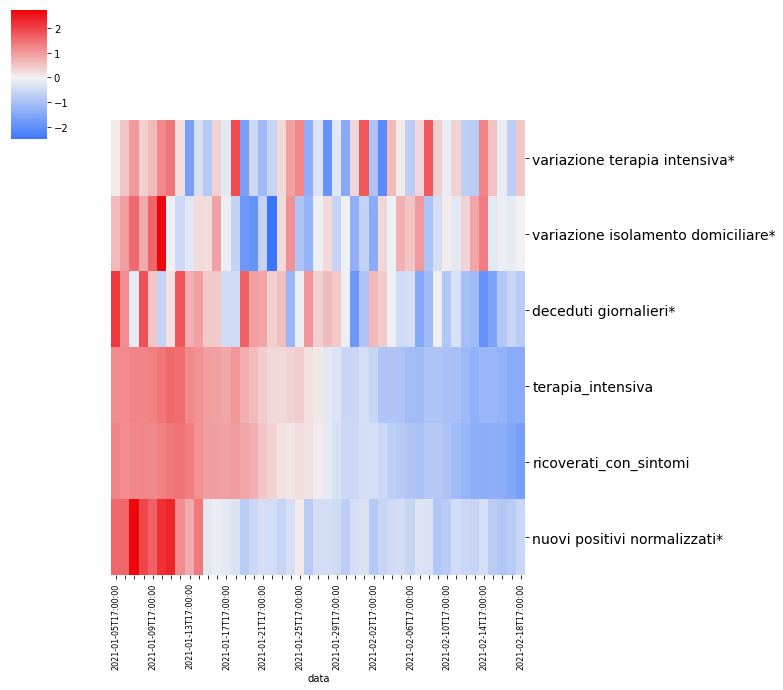

In [9]:
draw_bigmap(df, newcols2, lastdays=45)
print("Last 45 days")

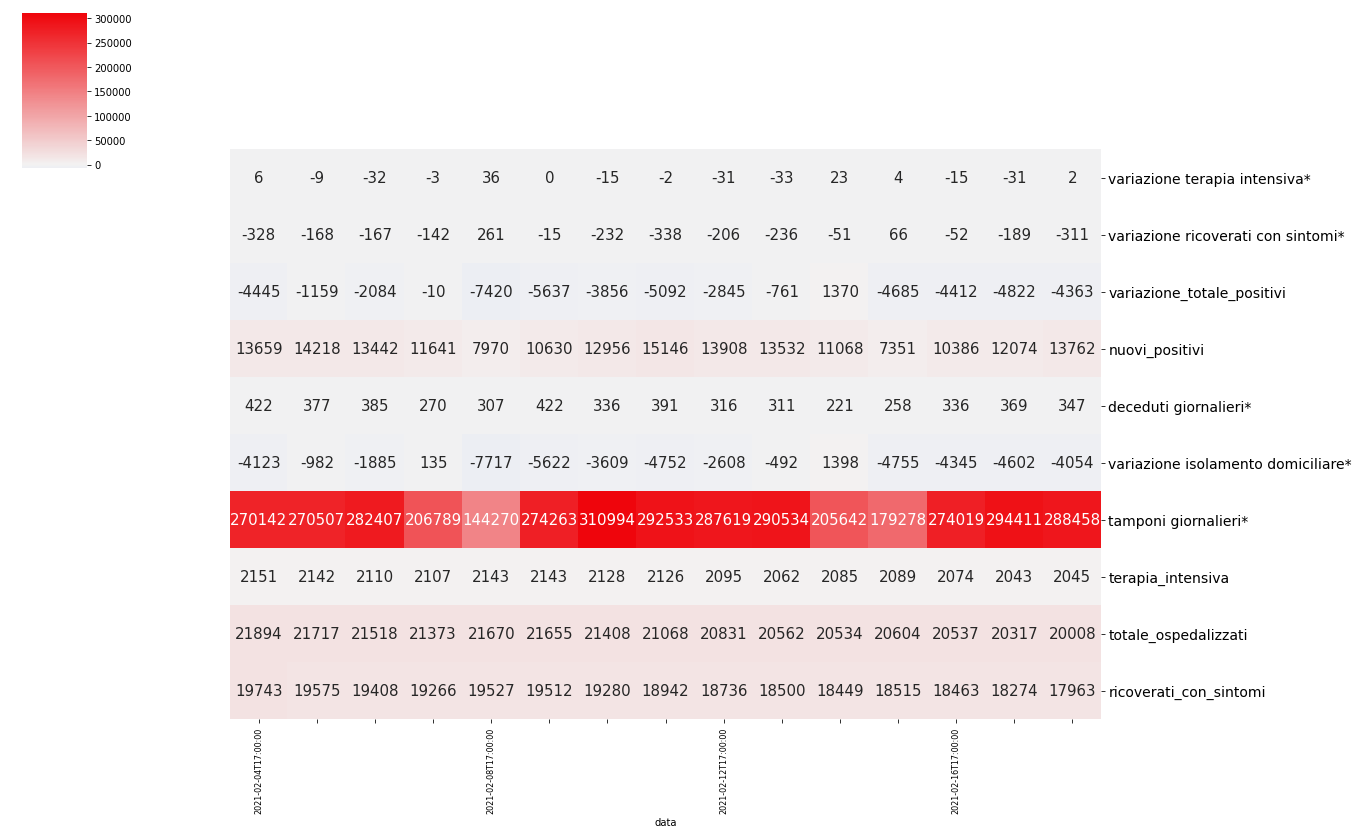

In [10]:
draw_bigmap(df, newcols, lastdays=15, annot=True, figsize=(18,12))

In [11]:
# line plots
def draw_lineplot(data, cols_list, title="", xlabel="", ylabel="", figsize=(6,4),
                  xlim=False, ylim=False, lastdays=None, dayrange=None,
                  despine=False,
                  
                  greenline=False, green_style="dashed", green_label="no variation",
                  orangeline=False, orange_height=250,
                  orange_style="dashed", orange_label="threshold",
                 ):
    
    """
    each cols_list element needs to be a valid data table header
    
    params
    ======
    dayrange: <tuple>; dayrange=(10,200)
    """
    
    
    
    if lastdays is not None and dayrange is None:
        data = data[-lastdays:]
    
    if dayrange is not None and lastdays is None:
        minday, maxday = dayrange
        #data = data[minday:maxday]
        
    if lastdays is not None and dayrange is not None:
        print("dayrange or lastdays: choose one")
        return
        
    TOTAL_DAYS = len(data)
    
    # drawing
    # -------
    plt.figure(figsize=figsize)
    for col in cols_list:
        y = list(data[col])
        x = list(range(len(y)))

        plt.plot(x, y)
        
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    
    if greenline:
        plt.hlines(0, 0, TOTAL_DAYS,
                   colors="green", label=green_label, linestyles=green_style
                  )
    if orangeline:
        plt.hlines(orange_height, 0, TOTAL_DAYS,
                   colors="orange", label=green_label, linestyles=green_style
                  )
    
    if dayrange:
        plt.xlim(minday, maxday)
        
    if despine:
        sns.despine(top=True, right=True, left=True, bottom=True)

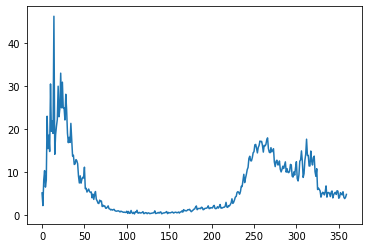

In [12]:
draw_lineplot(df, ["nuovi positivi normalizzati*"])

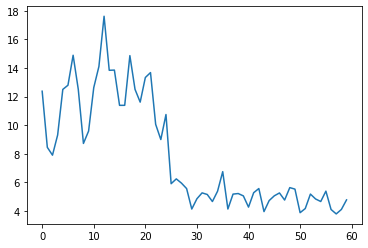

In [13]:
draw_lineplot(df, ["nuovi positivi normalizzati*"], lastdays=60)

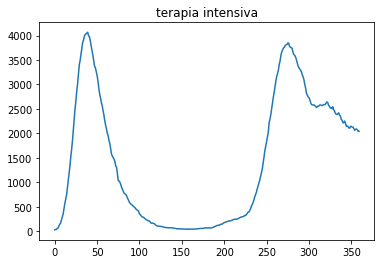

In [14]:
draw_lineplot(df, ["terapia_intensiva"], title="terapia intensiva")

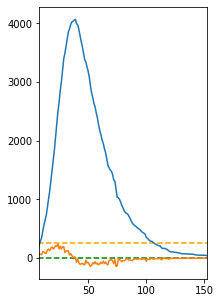

In [15]:
elems = ["terapia_intensiva", "variazione terapia intensiva*"]
CARE_250 = 216 # day 216: where roughly 250 other people are in intensive care
WINDOW = len(df) - CARE_250 # 25 on 21/10/2020

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, orange_height=250,
              dayrange=(8, WINDOW+8), figsize=(3,5))

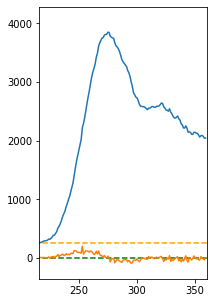

In [16]:
elems = ["terapia_intensiva", "variazione terapia intensiva*"]
dayrange = (CARE_250, CARE_250 + WINDOW)

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, orange_height=250,
              dayrange=dayrange, figsize=(3,5))

First day: 2020-02-24T18:00:00
Last day: 2021-02-18T17:00:00


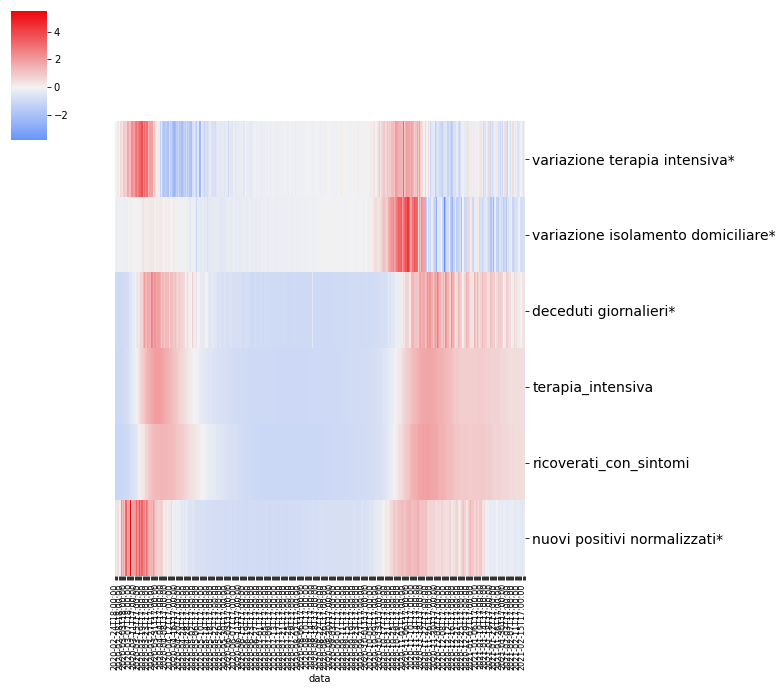

In [17]:
draw_bigmap(df, newcols2)
print(f"First day: {df.index[0]}")
print(f"Last day: {df.index[-1]}")

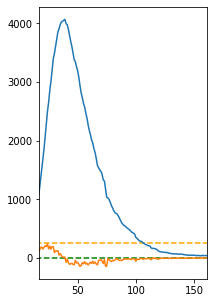

In [18]:
elems = ["terapia_intensiva", "variazione terapia intensiva*"]

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, orange_height=250,
              dayrange=(17, WINDOW+17), figsize=(3,5))

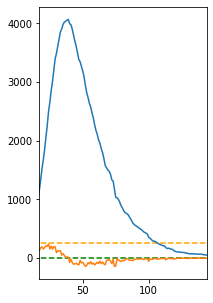

In [19]:
elems = ["terapia_intensiva", "variazione terapia intensiva*"]

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, orange_height=250,
              dayrange=(17, WINDOW), figsize=(3,5))

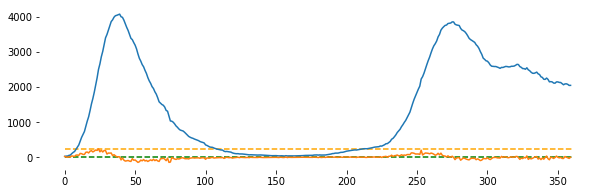

In [20]:
elems = ["terapia_intensiva", "variazione terapia intensiva*"]

# 8 is where roughly 250 people are in intensive care at the beginning of dataset
draw_lineplot(df, elems, greenline=True, orangeline=True, figsize=(10,3), despine=True)

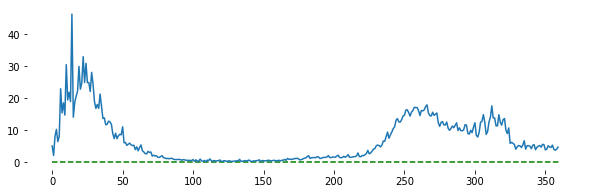

In [21]:
draw_lineplot(df, ["nuovi positivi normalizzati*"], greenline=True, figsize=(10,3), despine=True)

# regione per regione

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import requests
import os
# downloading the latest Protezione Civile data release

# color styling for heatmaps
bobmap = sns.diverging_palette(
        #127, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        260, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        s = 99,     # saturation (0 - 99)
        l = 50,     # lightness (0 - 99)
        center = "light",
        as_cmap = True,
    )

In [23]:
# creating a local database
# downloading the file, iff we don't have it

numeric_part = 20200224 # one less that the existing
filename = "dpc-covid19-ita-regioni-"
extension = ".csv"

success = 0
already = 0
for i in range(10_000):
    timestamp_days = str(numeric_part + i)[-2:]
    timestamp_days = int(timestamp_days)
    if timestamp_days > 31:
        continue
    
    timestamp_month = str(numeric_part + i)[-4:-2]
    timestamp_month = int(timestamp_month)
    if timestamp_month > 12:
        continue    
    
    curr_num = str(numeric_part + i)
    fullname = filename + curr_num + extension
    
    if os.path.exists(fullname):
        print(f"Skipping '{fullname}': got it already.{' '*30}", end="\r")
        already += 1
        continue
    else:
        print(f"Getting '{fullname}'.{' '*45}", end="\r")
        #            https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-20200331.csv
        #            https://github.com/pcm-dpc/COVID-19/blob/master/dati-regioni/dpc-covid19-ita-regioni-20200331.csv
        temp_url = f"https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/{fullname}"
        temp_req = requests.get(temp_url, allow_redirects=False)
        if temp_req.status_code == 404:
            continue
        with open(fullname, "wb") as o:
            o.write(temp_req.content)
        success += 1
        #break

print(f"\nAlready had: {already}")
print(f"Successfully downloaded: {success}")
print(f"Total files: {already + success}")

Getting 'dpc-covid19-ita-regioni-20210223.csv'.                                               
Already had: 359
Successfully downloaded: 2
Total files: 361


In [24]:
# performing operations on the database
import glob
from tqdm.notebook import tqdm
files = sorted(glob.glob("dpc-covid19-ita-regioni-*"))

In [25]:
INDEX = "codice_regione"
TARGET = "terapia_intensiva"

basedf = pd.read_csv(files[0], index_col=0)
wanted = ["denominazione_regione"]
basedf = basedf.set_index(INDEX)
basedf = basedf[wanted]

processed = [basedf]

for i, file in tqdm(enumerate(files)):
    tempdf = pd.read_csv(file, index_col=0)
    colname = tempdf.index[0] # using the date as column name
    
    tempdf = tempdf.set_index(INDEX)
    tempdf = tempdf[[TARGET]]
    
    tempdf = tempdf.rename(columns={TARGET: colname})
    processed.append(tempdf)

regioni = pd.concat(processed, axis=1)
regioni.to_csv("regioni.tsv", sep="\t")

0it [00:00, ?it/s]

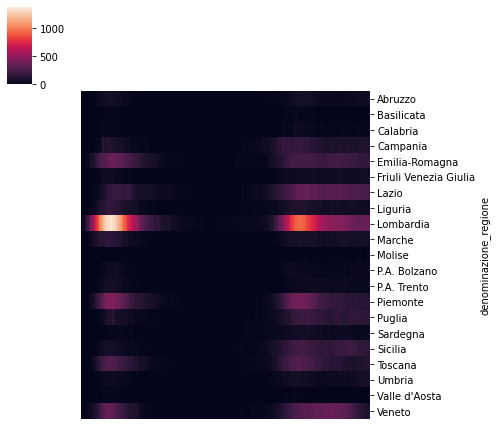

In [26]:
data = regioni.set_index("denominazione_regione")
figsize=(7,6)
clus = sns.clustermap(
    data,
    #z_score=0, cmap=bobmap,
    col_cluster=False, row_cluster=False,
    xticklabels=False,
    #metric=metric,
    figsize=figsize,
    #center=center,
)

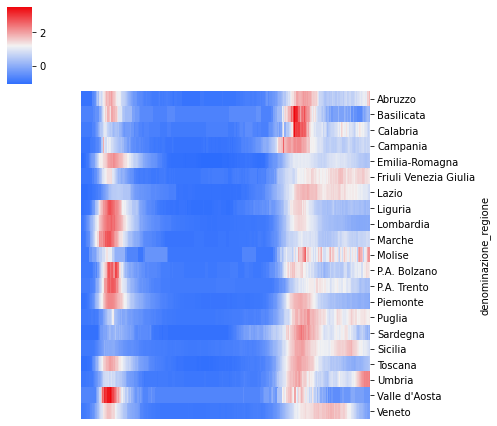

In [27]:
figsize=(7,6)
clus = sns.clustermap(
    data, z_score=0, cmap=bobmap,
    col_cluster=False, row_cluster=False,
    xticklabels=False,
    #metric=metric,
    figsize=figsize,
    #center=center,
)

# provincia per provincia

In [41]:
#https://github.com/pcm-dpc/COVID-19

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import requests
import os
# downloading the latest Protezione Civile data release

# color styling for heatmaps
bobmap = sns.diverging_palette(
        #127, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        260, 12,    # HUSL coordinates, get the H: http://www.hsluv.org/ (0-359)
        s = 99,     # saturation (0 - 99)
        l = 50,     # lightness (0 - 99)
        center = "light",
        as_cmap = True,
    )

In [63]:
# creating a local database
# downloading the file, iff we don't have it

numeric_part = 20200224 # one less that the existing
filename = "dpc-covid19-ita-province-"
extension = ".csv"

success = 0
already = 0
for i in range(10_000):
    timestamp_days = str(numeric_part + i)[-2:]
    timestamp_days = int(timestamp_days)
    if timestamp_days > 31:
        continue
    
    timestamp_month = str(numeric_part + i)[-4:-2]
    timestamp_month = int(timestamp_month)
    if timestamp_month > 12:
        continue    
    
    curr_num = str(numeric_part + i)
    fullname = filename + curr_num + extension
    
    if os.path.exists(fullname):
        print(f"Skipping '{fullname}': got it already.{' '*30}", end="\r")
        already += 1
        continue
    else:
        #            https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-20200331.csv
        #            https://github.com/pcm-dpc/COVID-19/blob/master/dati-regioni/dpc-covid19-ita-regioni-20200331.csv
        temp_url = f"https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/{fullname}"
        temp_req = requests.get(temp_url, allow_redirects=False)
        if temp_req.status_code == 404:
            continue
        print(f"Getting '{fullname}'.{' '*45}", end="\r")
        with open(fullname, "wb") as o:
            o.write(temp_req.content)
        success += 1
        #break

print(f"\nAlready had: {already}")
print(f"Successfully downloaded: {success}")
print(f"Total files: {already + success}")

Skipping 'dpc-covid19-ita-province-20210218.csv': got it already.                              
Already had: 361
Successfully downloaded: 0
Total files: 361


In [75]:
# performing operations on the database
import glob
from tqdm.notebook import tqdm
files = sorted(glob.glob("dpc-covid19-ita-province-*"))

In [76]:
INDEX = "sigla_provincia"
TARGET = "totale_casi"

basedf = pd.read_csv(files[0], index_col=0)
wanted = ["denominazione_regione", "denominazione_provincia", "sigla_provincia", "totale_casi"]

# selecting for Lombardia; dropping uncertain data
basedf = basedf[wanted]
basedf = basedf[basedf["denominazione_regione"] == "Lombardia"].dropna()
basedf = basedf.set_index(INDEX)

processed = [basedf]

for i, file in tqdm(enumerate(files)):
    tempdf = pd.read_csv(file, index_col=0)
    
    colname = tempdf.index[0] # using the date as column name
    
    tempdf = tempdf[wanted]
    tempdf = tempdf[tempdf["denominazione_regione"] == "Lombardia"].dropna()
    tempdf = tempdf.set_index(INDEX)
    tempdf = tempdf[[TARGET]]
    
    tempdf = tempdf.rename(columns={TARGET: colname})
    processed.append(tempdf)

lombardia = pd.concat(processed, axis=1)
lombardia.to_csv("lombardia.tsv", sep="\t")

0it [00:00, ?it/s]

In [77]:
lombardia = lombardia.set_index("denominazione_provincia")

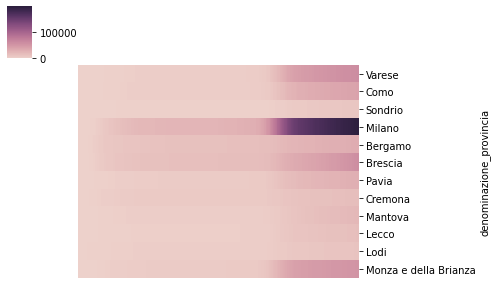

In [78]:
figsize=(7,4)
clus = sns.clustermap(
    lombardia[lombardia.columns[2:]],
    #z_score=0,
    cmap=sns.cubehelix_palette(as_cmap=True),
    col_cluster=False, row_cluster=False,
    xticklabels=False,
    #metric=metric,
    figsize=figsize,
    #center=center,
)

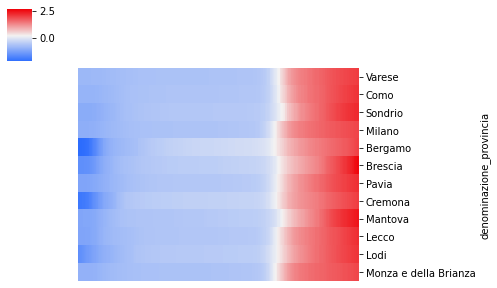

In [79]:
figsize=(7,4)
clus = sns.clustermap(
    lombardia[lombardia.columns[2:]],
    z_score=0,
    cmap=bobmap,
    col_cluster=False, row_cluster=False,
    xticklabels=False,
    #metric=metric,
    figsize=figsize,
    #center=center,
)

In [80]:
# dati google 2019
abitanti_per_provincia = {
    "Varese": 890_768,
    "Como": 599_204,
    "Sondrio": 181_095,
    "Milano": 3_250_000,
    "Bergamo": 1_115_000,
    "Brescia": 1_266_000,
    "Pavia": 545_888,
    "Cremona": 358_955,
    "Mantova": 412_292,
    "Lecco": 337_380,
    "Lodi": 230_198,
    "Monza e della Brianza": 873_935,
}

In [81]:
import numpy as np

lombardia = pd.concat(processed, axis=1)
data = lombardia.set_index("denominazione_provincia").copy()
del data["denominazione_regione"]

processed = []
for provincia, abitanti in abitanti_per_provincia.items():
    arr = data.loc[provincia]
    arr = (arr / abitanti) * 100
    processed.append(arr)

In [82]:
newdataset = {k:v for k,v in zip(abitanti_per_provincia.keys(), processed)}

In [83]:
normalized_lombardia = pd.DataFrame(newdataset)

In [84]:
normalized_lombardia = normalized_lombardia.T

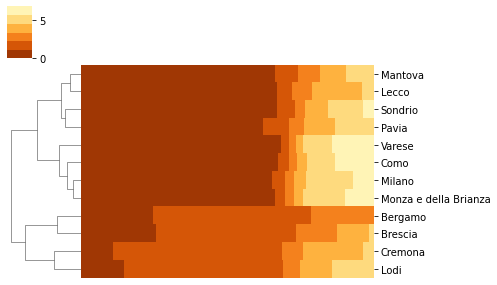

In [85]:
figsize=(7,4)
clus = sns.clustermap(
    normalized_lombardia[normalized_lombardia.columns[1:]],
    #z_score=0,
    cmap=sns.color_palette("YlOrBr_r", as_cmap=False),
    col_cluster=False, row_cluster=True,
    xticklabels=False,
    metric="Cityblock",
    figsize=figsize,
    #center=center,
)